### Tweeter NLP Data
#### 1. Imports and EDA

In [1]:
# !pip install scikit-learn-intelex
# !pip freeze | grep -E 'ydata-profiling|visions'

In [2]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from ydata_profiling.config import Settings

import re
import os
import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For classification metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay,     average_precision_score

# For dealing with imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Support Vector Optimizers
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import TruncatedSVD


# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

# Additional settings...
config = Settings()
# Disable chi-square test for numeric variables
config.vars.num.chi_squared_threshold = 0.0

%load_ext autoreload
%autoreload 2
%matplotlib inline

df_raw = pd.read_csv('./data/nlp_tweet/tweet_data.csv')
df = df_raw.copy()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [3]:
df.sample(15).T

438846  \
tweetID                                   1121466455911014400   
crDate                                    2019-04-25 17:30:13   
edInput                                                     1   
editor                                                   5003   
engages                                                   811   
isApproved                                               True   
isEdNeed                                                 True   
isRT                                                    False   
likes                                                     625   
photoUrl                                                  NaN   
retweets                                                  186   
rtUsID                                                     -1   
text                  Cute reaction 😂 https://t.co/QXiVFGFiMF   
topicName                                              Animal   
usFlwrs                                                108535   
usID                                       942754965528895488   
usName                                          I_love_nature   
videoUrl    https://video.twimg.com/ext_tw_video/112067457...   

                                                       118118  \
tweetID                                   1087001805832089600   
crDate                                    2019-01-20 15:00:00   
edInput                                                     1   
editor                                                   5001   
engages                                                    56   
isApproved                                               True   
isEdNeed                                                 True   
isRT                                                    False   
likes                                                      45   
photoUrl                                                  NaN   
retweets                                                   11   
rtUsID                                                     -1   
text        Friends helps other friends FAIL! 🤣🤣🤣 https://...   
topicName                                               Memes   
usFlwrs                                                 98989   
usID                                                167491068   
usName                                                    AFV   
videoUrl    https://video.twimg.com/amplify_video/10864459...   

                                                       517172  \
tweetID                                   1129782706575958017   
crDate                                    2019-05-18 16:16:02   
edInput                                                    -1   
editor                                                     -1   
engages                                                    11   
isApproved                                              False   
isEdNeed                                                 True   
isRT                                                    False   
likes                                                       7   
photoUrl      https://pbs.twimg.com/media/D63LYj7X4AAdyfu.jpg   
retweets                                                    4   
rtUsID                                                     -1   
text        Exxon evacuates foreign staff from Iraqi oilfi...   
topicName                                            Business   
usFlwrs                                               2021292   
usID                                                 15110357   
usName                                       Reuters Business   
videoUrl                                                  NaN   

                                                       360387  \
tweetID                                   1113460768555642880   
crDate                                    2019-04-03 15:18:28   
edInput                                                    -1   
editor                                                     -1   
engages               

In [4]:
# Runs Auto-EDA of data, see tweet_EDA_report.html in project folder magnimind_projects
# profile = ProfileReport(df, title='Tweet Profile Report', explorative=True, config=config)
# profile.to_file('tweet_EDA_report.html')

### 2. Feature Selections and Word Cloud

In [5]:
df_reduced = df[['editor', 'topicName', 'text', 'edInput']].copy()
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785916 entries, 0 to 785915
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   editor     785916 non-null  int64 
 1   topicName  785916 non-null  object
 2   text       785916 non-null  object
 3   edInput    785916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 24.0+ MB


In [6]:
stop_words = set(stopwords.words('english'))

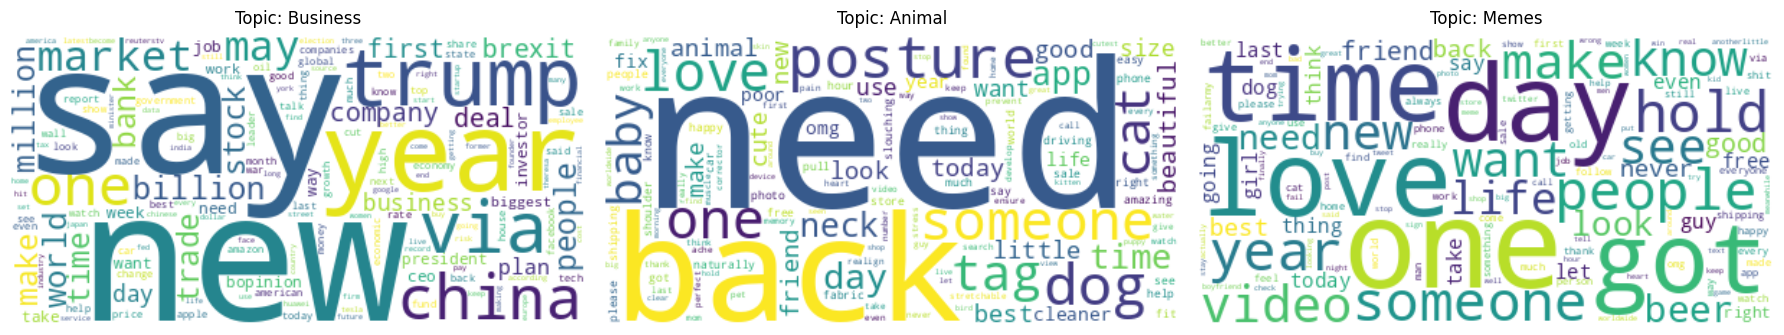

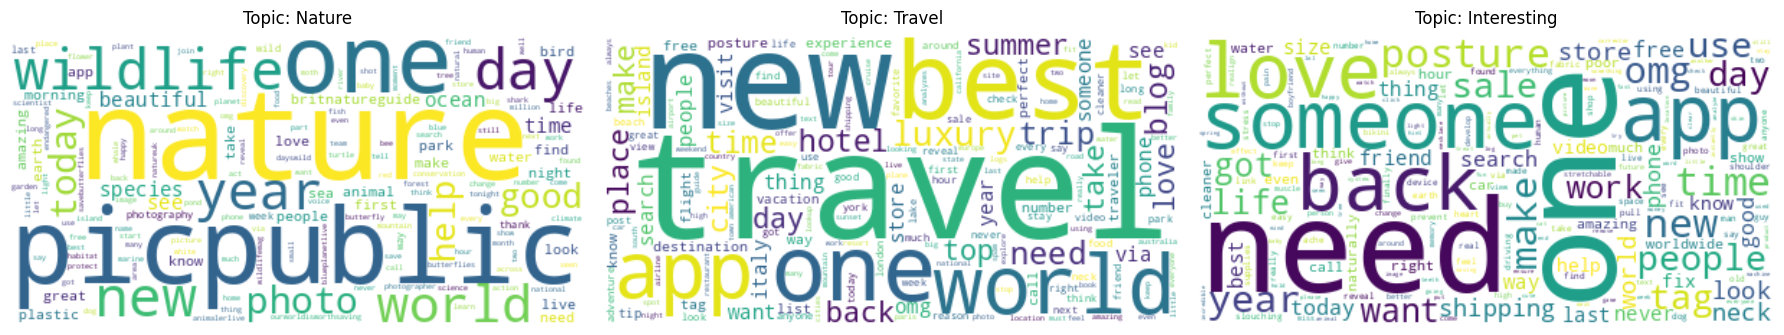

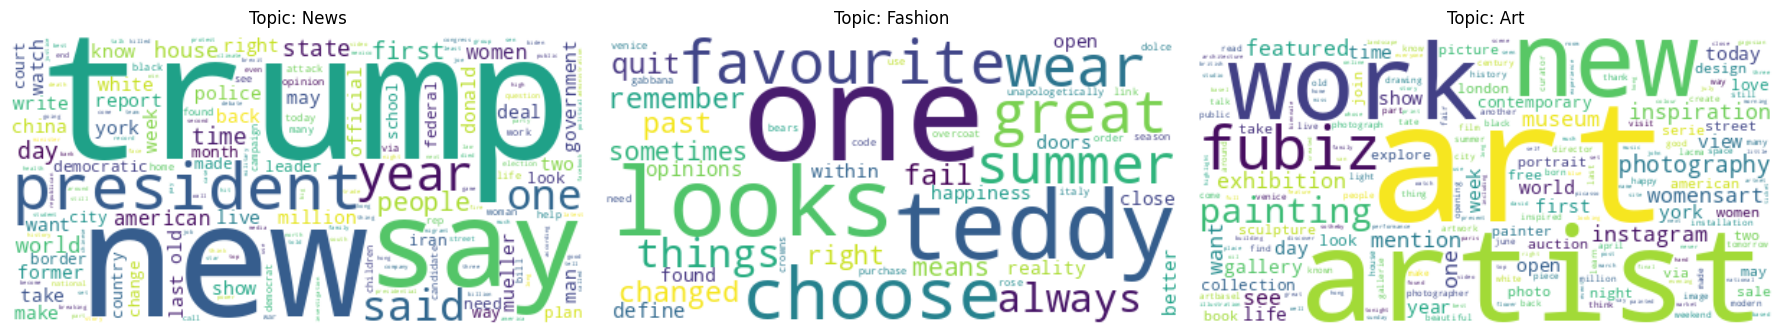

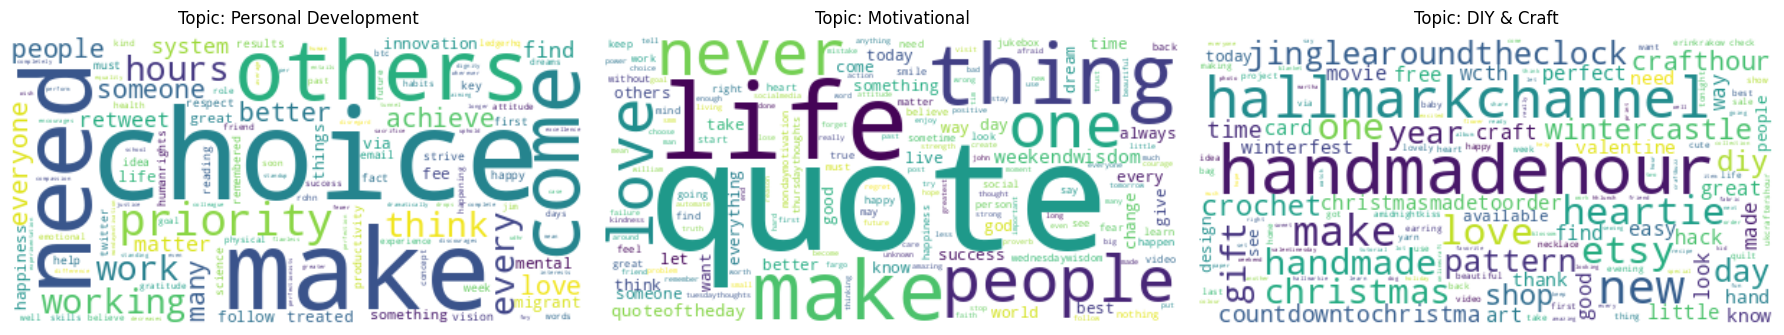

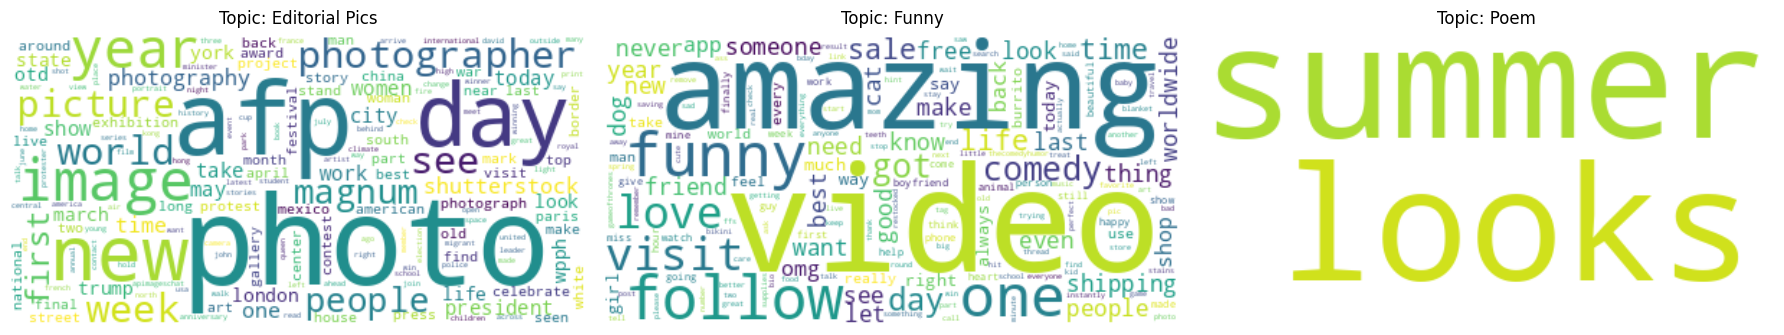

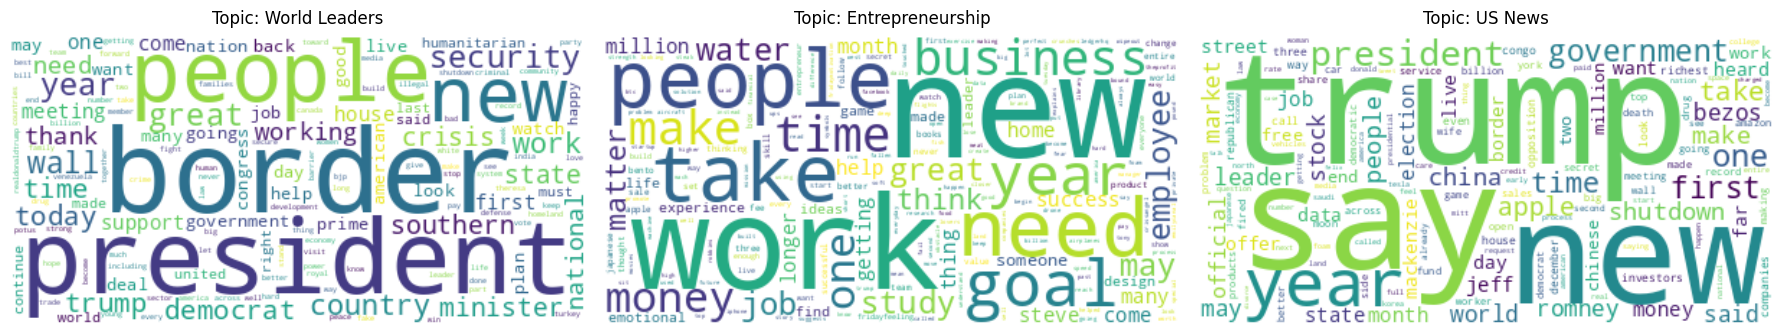

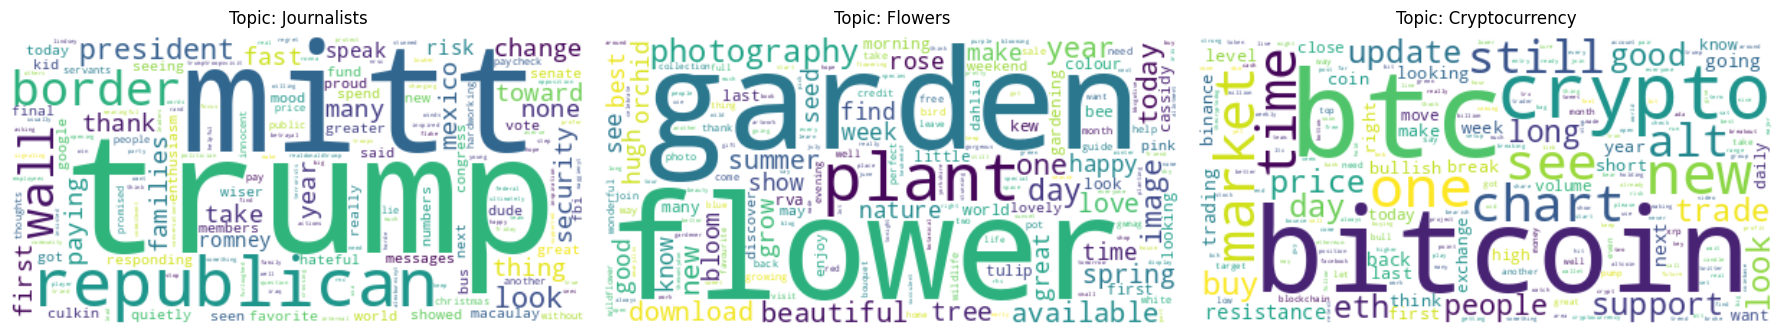

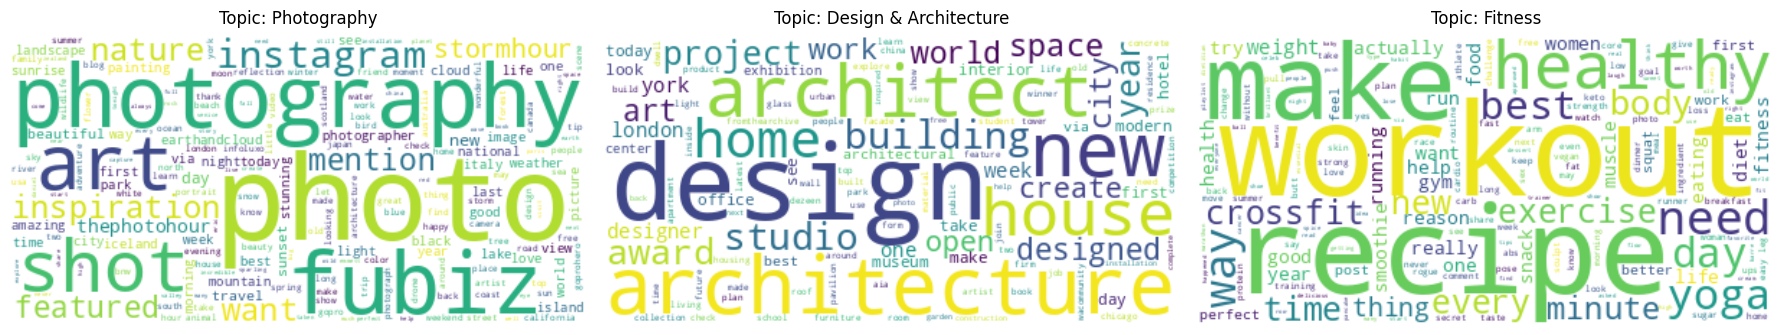

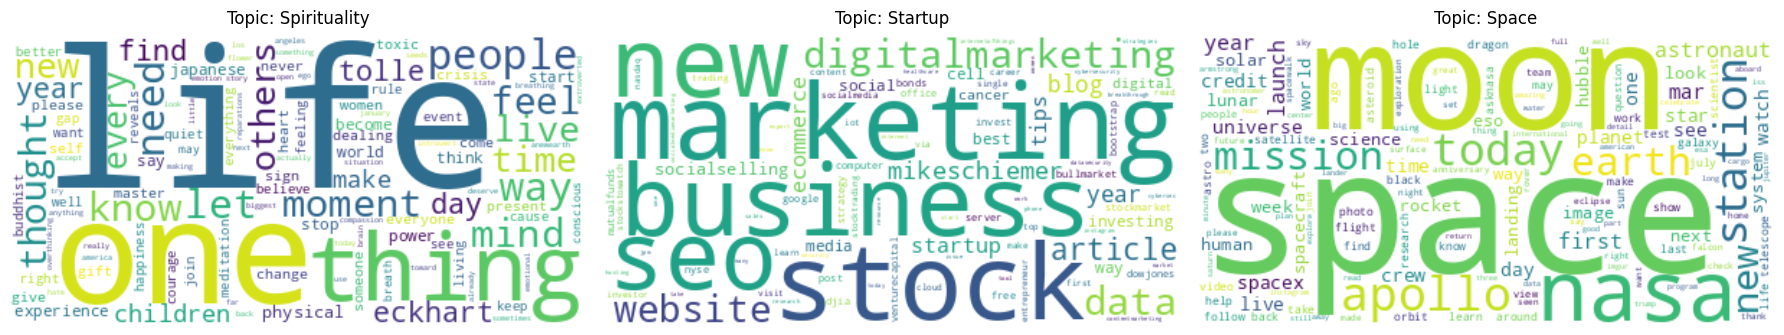

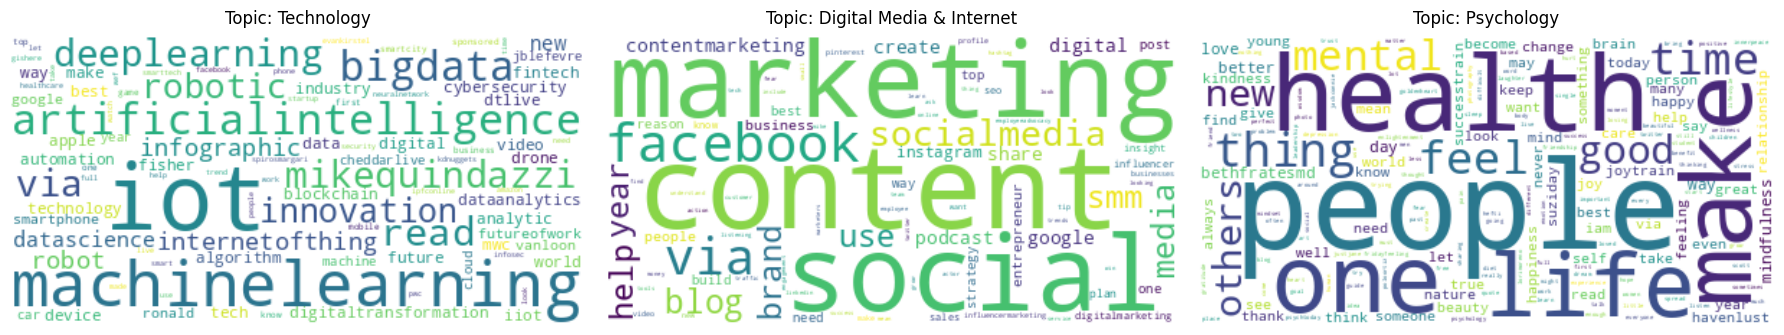

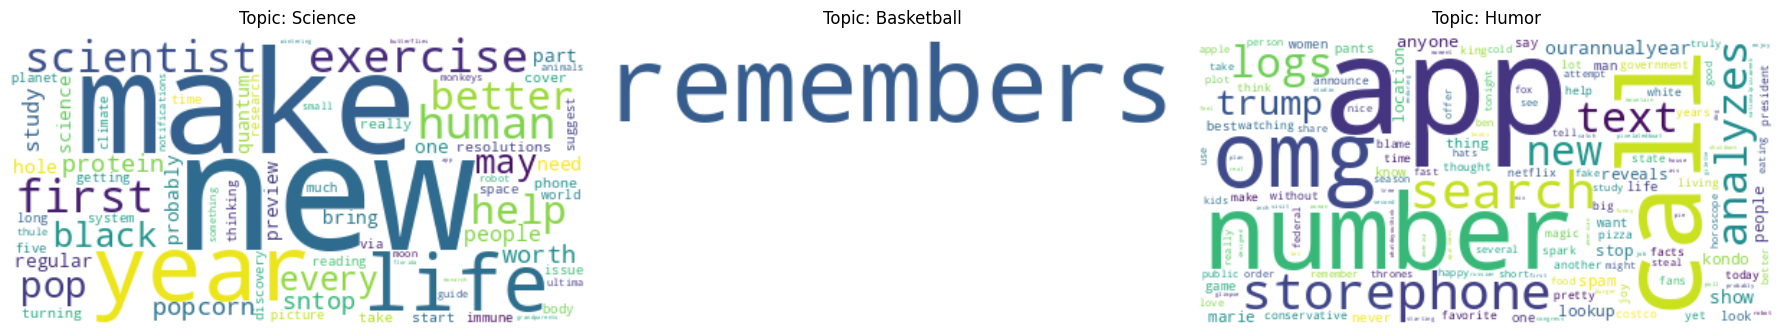

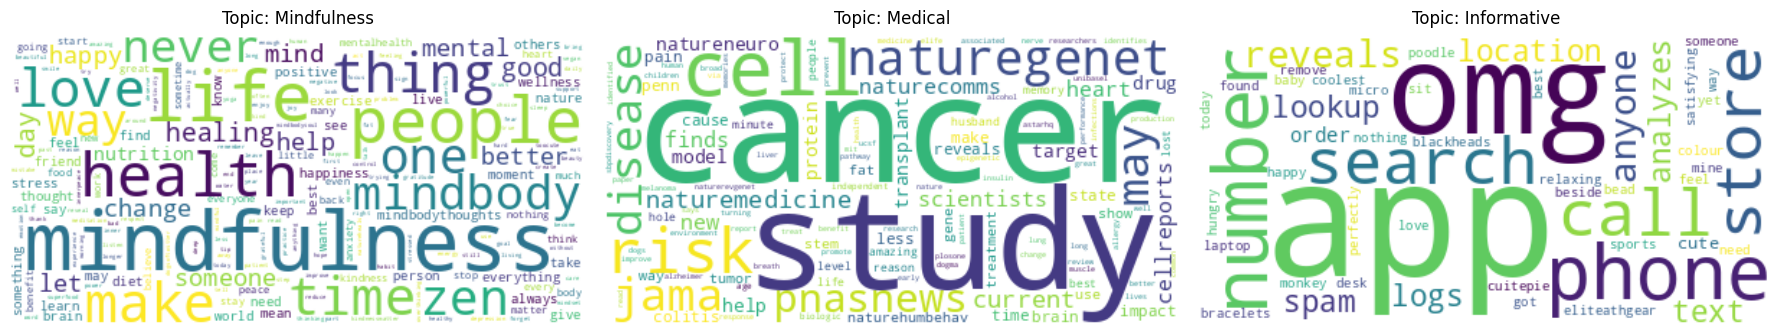

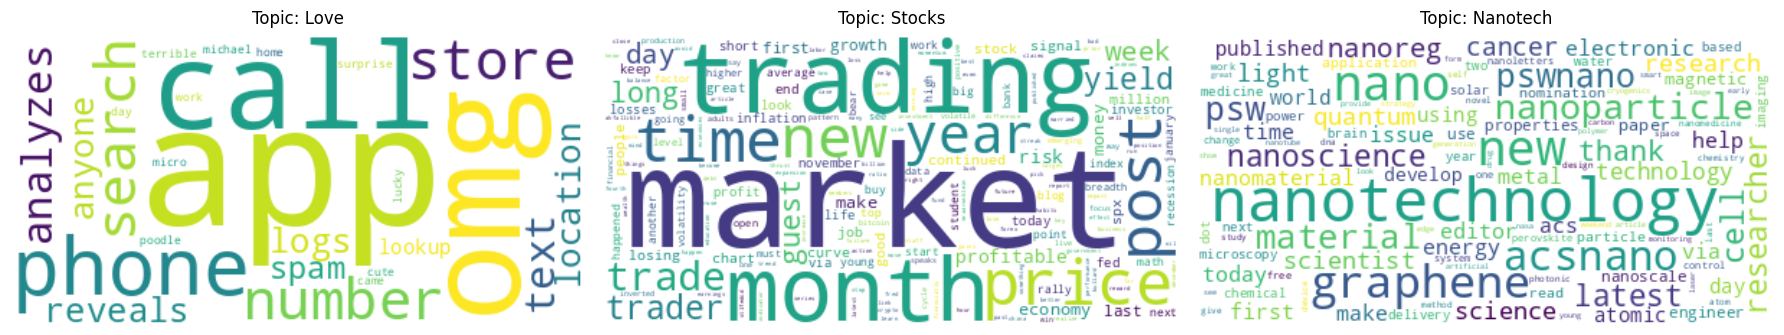

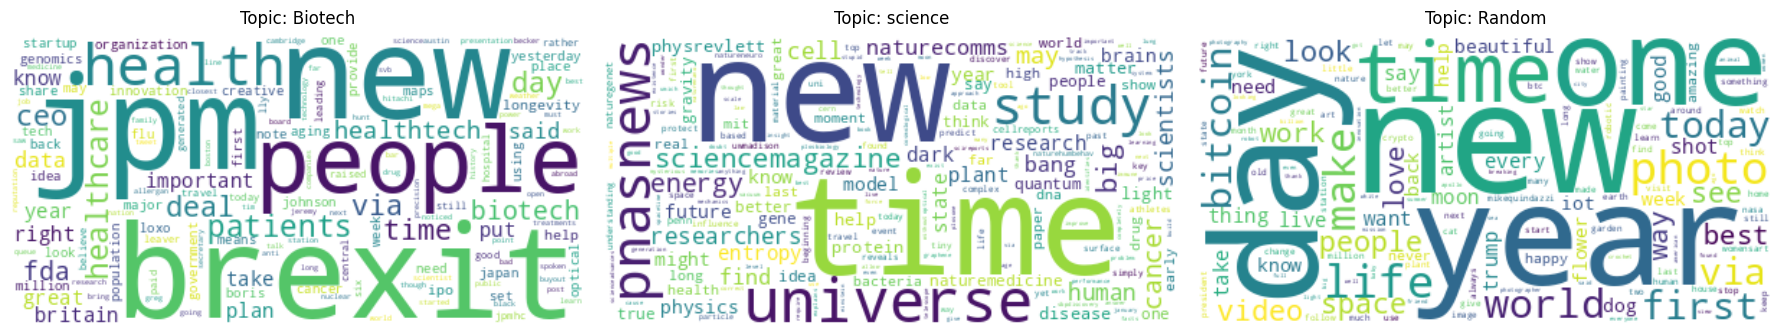

In [7]:
# Define a text-cleaning function
# Generate word clouds for each topicName
# We group rows by topicName, concatenate the cleaned text, and make a WordCloud.

stop_words = set(stopwords.words('english'))

def cleanup_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    # Keep only letters + whitespace; make lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text).lower()
    # Tokenize on whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Keep tokens > 2 characters, purely alphabetical
    tokens = [t for t in tokens if t.isalpha() and len(t) > 2]
    return ' '.join(tokens)

df_reduced['cleaned_text'] = df_reduced['text'].apply(cleanup_text)

topics = df_reduced['topicName'].unique()

chunk_size = 3
for i in range(0, len(topics), chunk_size):
    # For this figure, grab up to 3 topics
    chunk = topics[i:i+chunk_size]
    
    # Create one figure to hold up to 3 columns
    # Adjust figsize as you like
    fig = plt.figure(figsize=(18, 6))

    for j, topic in enumerate(chunk):
        # Gather text for this topic
        group = df_reduced[df_reduced['topicName'] == topic]
        all_text = " ".join(group['cleaned_text'])
        
        # Generate the word cloud
        wordcloud = WordCloud(background_color='white', 
                              collocations=False
                             ).generate(all_text)
        
        # Manually place an Axes in the figure:
        # e.g., 3 columns => each ~0.33 wide
        left = 0.01 + 0.33*j   # shift each axis horizontally
        ax = fig.add_axes([left, 0.05, 0.32, 0.85]) 
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f"Topic: {topic}", pad=10)
        ax.axis("off")
    
    # Show the figure for this set of 3 topics
    plt.show()
    plt.close(fig)

### 3. Predict edInput

In [8]:
df_model = df_reduced[['editor', 'topicName', 'cleaned_text', 'edInput']].copy()
print(f'{df_model.info()}\n')
##############################################################################
# 1. DATA PREP (Assume df_model has "editor", "topicName", "cleaned_text", "edInput")
##############################################################################

# For example: map y from {1,2,3} => {0,1,2} if not already done
df_model['edInput'] = df_model['edInput'].replace({-1:3, 3:3, 4:3}).copy()  # (-1,3,4 => 3; 1 => 1; 2 => 2)
df_model['edInput'] = df_model['edInput'].replace({1:0, 2:1, 3:2}).copy()
print(f'{df_model['edInput'].value_counts()}')

X = df_model[['editor', 'topicName', 'cleaned_text']]
y = df_model['edInput']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,       
    random_state=42,
    stratify=y
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785916 entries, 0 to 785915
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   editor        785916 non-null  int64 
 1   topicName     785916 non-null  object
 2   cleaned_text  785916 non-null  object
 3   edInput       785916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 24.0+ MB
None

edInput
2    463598
0    215577
1    106741
Name: count, dtype: int64


In [9]:
##############################################################################
# 2. PREPROCESSOR (TF-IDF -> TruncatedSVD -> MinMaxScaler, plus OHE for cat)
##############################################################################

text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=350)),
    ('svd', TruncatedSVD(n_components=11)),
    ('minmax', MinMaxScaler(feature_range=(0,1)))
])

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_pipeline, 'cleaned_text'),
        ('cat',  cat_pipeline,  ['editor', 'topicName'])
    ],
    remainder='drop'
)


In [10]:
##############################################################################
# 3. DEFINE MODELS AND PARAM GRIDS
##############################################################################

# We'll do a dictionary: { model_name: (model, param_grid) }
# Adjust the ranges to what makes sense for your data!

models_and_grids = {
    'LogisticRegression': (
        LogisticRegression(
            max_iter=1000,
            class_weight={0:1, 1:2, 2:1}  # multi-class weighting
        ),
        {
            'classifier__C': [0.1, 1, 10]
        }
    ),
    'RandomForest': (
        RandomForestClassifier(
            class_weight={0:1, 1:2, 2:1},
            n_jobs=-1
        ),
        {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None]
        }
    ),
    'XGBoost': (
        XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_jobs=-1
            # class_weight not used for multi-class
        ),
        {
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [6, 10]
        }
    ),
    'SGDClassifier': (
        SGDClassifier(
            loss='hinge',  # linear SVM-like
            penalty='l2',
            random_state=42,
            n_jobs=-1
        ),
        {
            'classifier__alpha': [1e-4, 1e-3, 1e-2],
            'classifier__max_iter': [1000, 2000]
        }
    ),
    # Include or remove Naive Bayes as you wish
    'NaiveBayes': (
        MultinomialNB(), 
        {
            # NB doesn't support class_weight, can still use SMOTE for minority classes
            'classifier__alpha': [1.0, 0.1, 0.01]
        }
    )
}

##############################################################################
# 4. CREATE ./models DIRECTORY IF NOT EXISTS
##############################################################################
os.makedirs("./models", exist_ok=True)


In [ ]:
##############################################################################
# 5. GRID SEARCH OVER EACH MODEL, SAVE BEST ESTIMATOR
##############################################################################
from sklearn.model_selection import StratifiedKFold

# Use an imblearn pipeline so we can do SMOTE + classifier
# We'll only vary 'classifier__...' params in param_grid

# We do a simple 3-fold CV. Tweak as desired.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for model_name, (model, param_grid) in models_and_grids.items():
    print(f"\n=== Grid Searching: {model_name} ===")
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE()),   # Oversample minority classes
        ('classifier', model)
    ])
    
    # For multi-class tasks, you might want 'f1_macro' or 'accuracy'
    # Adjust scoring as you prefer
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1,         # parallel search
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print("Best Params:", grid_search.best_params_)
    print("Best CV Score:", f"{grid_search.best_score_:.3f}")
    
    # Save the best estimator (including pipeline steps)
    best_model_path = f"./models/{model_name}_best.joblib"
    joblib.dump(grid_search.best_estimator_, best_model_path)
    print(f"Saved best {model_name} to {best_model_path}")


=== Grid Searching: LogisticRegression ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Params: {'classifier__C': 10}
Best CV Score: 0.692
Saved best LogisticRegression to ./models/LogisticRegression_best.joblib

=== Grid Searching: RandomForest ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Params: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best CV Score: 0.774
Saved best RandomForest to ./models/RandomForest_best.joblib

=== Grid Searching: XGBoost ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:33:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:33:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:33:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn

Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10}
Best CV Score: 0.772
Saved best XGBoost to ./models/XGBoost_best.joblib

=== Grid Searching: SGDClassifier ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [ ]:
##############################################################################
# 6. LOAD THE BEST ESTIMATORS AND PRINT CLASSIFICATION REPORTS
##############################################################################
for model_name in models_and_grids.keys():
    best_model_path = f"./models/{model_name}_best.joblib"
    print(f"\n=== Loading best {model_name} ===")
    best_pipeline = joblib.load(best_model_path)
    
    # Predict on the test set
    y_pred = best_pipeline.predict(X_test)
    
    # Show classification metrics
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

In [ ]:
# Classification: 
# 0 = 1, 1 = 2, 3 = {-1, 3, 4}

### Narrow ML Definition
1. Focus on limited topicNames, business, news, etc...
2. edInput limit to 1 and 2
3. Refactor certain stopwords 
4. Reduce number fo models
5. Show confusion matrix

In [ ]:
df2 = df_raw.copy()

In [ ]:
df2.info()

In [ ]:
# topicName selections
df2['topicName'].value_counts()

In [ ]:
####################
# Work on Business #
####################

# Get needed features
df_business = df2[['topicName', 'text', 'edInput']].copy()

# Filter df2 for rows with topicName 'News' or 'US News'
df_business = df_business[df_business['topicName'].isin(['Business', 'Startup', 'Entrepreneurship'])].copy()

# Merge the two categories by setting topicName to 'News'
df_business.loc[:, 'topicName'] = 'Business'

import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

# Optionally, define stop words (unused in filtering here since we want to keep them)
stop_words = set(stopwords.words('english'))

# Use TweetTokenizer to better handle tweet text
tknzr = TweetTokenizer()

def cleanup_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    # Tokenize the tweet while preserving common punctuation for sentiment/emphasis (e.g. !, ?, #, @)
    tokens = tknzr.tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        # If the token is fully uppercase and short (likely an acronym like "US"), keep it as is
        if token.isupper() and len(token) <= 3:
            cleaned_tokens.append(token)
        else:
            # Otherwise, lower-case the token
            cleaned_tokens.append(token.lower())
    # Rejoin tokens into a single string and return
    return ' '.join(cleaned_tokens)

df_business['cleaned_text'] = df_business['text'].apply(cleanup_text)

# Show Side by Side Before and After Tweek Tokenizer Treatment
# Filter news tweets from df_reduced (if not already filtered)
df_reduced_business = df_reduced[df_reduced['topicName'].isin(['Business', 'Startup', 'Entrepreneurship'])].copy()

# Concatenate all cleaned text for news tweets from each DataFrame
news_text_before = " ".join(df_reduced_business['cleaned_text'])
news_text_after  = " ".join(df_business['cleaned_text'])

# Generate word clouds for each dataset
wordcloud_before = WordCloud(background_color='white', collocations=False).generate(news_text_before)
wordcloud_after  = WordCloud(background_color='white', collocations=False).generate(news_text_after)

# Create a side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot for df_reduced (Before Tweet Tokenizer)
axes[0].imshow(wordcloud_before, interpolation='bilinear')
axes[0].set_title("Business Tweets Before Tweet Tokenizer", fontsize=16)
axes[0].axis("off")

# Plot for df_news (After Tweet Tokenizer)
axes[1].imshow(wordcloud_after, interpolation='bilinear')
axes[1].set_title("Business Tweets After Tweet Tokenizer", fontsize=16)
axes[1].axis("off")

plt.show()


In [ ]:
df_business.info()

In [ ]:
df_business.edInput.value_counts()

In [ ]:
df_business.topicName.value_counts()

In [ ]:
##############################################################################
# 1. DATA PREP (Assume df_model has "editor", "topicName", "cleaned_text", "edInput")
##############################################################################

df_model_biz = df_business[df_business['edInput'].isin([1, 2])].copy()
df_model_biz['edInput'] = df_model_biz['edInput'].replace({1:1, 2:0,}).copy() # positive class should be 1, not 0 {1:1, 2:0,} for binary classification
print(f'{df_model_biz['edInput'].value_counts()}')

X = df_model_biz[['cleaned_text']]
y = df_model_biz['edInput']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       
    random_state=42,
    stratify=y
)

In [ ]:
##############################################################################
# 2. PREPROCESSOR (TF-IDF -> TruncatedSVD -> MinMaxScaler, plus OHE for cat)
##############################################################################
lemmatizer = WordNetLemmatizer()
my_stopwords = set(stopwords.words('english'))  # or a custom set

def custom_tokenizer_lemmatize(text):
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text).lower().strip()
    tokens = word_tokenize(text)
    
    # Lemmatize
    lemmed = [lemmatizer.lemmatize(t) for t in tokens if len(t) > 1]
    
    # Remove lemmed tokens if their original or their lemma is in your stopwords
    final_tokens = []
    for orig, lm in zip(tokens, lemmed):
        if orig not in my_stopwords and lm not in my_stopwords:
            final_tokens.append(lm)
            
    return final_tokens
    
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=500,
                              tokenizer=custom_tokenizer_lemmatize,
                              ngram_range=(1, 2),
                              max_df=0.8,
                              min_df=5,
                              sublinear_tf=True,
                              stop_words=None,
                              token_pattern=None,     # to silence the warning
                             )
    ), # can add more parameters here TfidfVect.....
    ('svd', TruncatedSVD(n_components=50)),
    ('minmax', MinMaxScaler(feature_range=(0,1)))
])

# cat_pipeline = Pipeline([
#     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
# ])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_pipeline, 'cleaned_text'),
        # ('cat',  cat_pipeline,  ['editor', 'topicName'])
    ],
    remainder='drop'
)

In [ ]:
##############################################################################
# 3. DEFINE MODELS AND PARAM GRIDS
##############################################################################

# We'll do a dictionary: { model_name: (model, param_grid) }
# Adjust the ranges to what makes sense for your data!

models_and_grids = {
    'LogisticRegression': (
        LogisticRegression(
            max_iter=1000,
            # class_weight={0:1, 1:1,}  # multi-class weighting example, may still want to try it for imbalanced
        ),
        {
            # Tfidf parameters (apply to the "tfidf" step inside the ColumnTransformer)
            'preprocessor__text__tfidf__ngram_range': [ (1,1), (1,2) ],
            'preprocessor__text__tfidf__max_df': [0.7, 0.9],
            
            # SVD parameter
            # 'preprocessor__text__svd__n_components': [11, 15],  # if you want to vary # of components

            # LogisticRegression parameter
            'classifier__C': [1e-3, 1e-2, 1e-1, 1, 10, 100]
        }
    ),
    
    'NaiveBayes': (
        MultinomialNB(), 
        {
            # Tfidf parameters
            'preprocessor__text__tfidf__ngram_range': [ (1,1), (1,2) ],
            'preprocessor__text__tfidf__max_df': [0.7, 0.9],
            
            # NB-specific
            'classifier__alpha': [1.0, 0.1, 0.01],
            'classifier__fit_prior': [True, False],
        }
    ),
    
    'XGBoost': (
        XGBClassifier(
            eval_metric='mlogloss',
            n_jobs=-1
            # No class_weight param for multi-class in XGBoost
        ),
        {
            # Tfidf parameters
            'preprocessor__text__tfidf__ngram_range': [ (1,1), (1,2) ],
            'preprocessor__text__tfidf__max_df': [0.7, 0.9],
            
            # XGBoost parameters
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__max_depth': [6, 10],
            'classifier__n_estimators': [100, 200],
            'classifier__subsample': [0.8, 1.0],
        }
    ),
}

In [ ]:
###############################################################################
# 4. SETUP CROSS-VALIDATION
###############################################################################
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

###############################################################################
# 5. GRID SEARCH OVER EACH MODEL
###############################################################################
os.makedirs("./models", exist_ok=True)

# The function below returns -fp (negative false positives).
# By default, GridSearchCV maximizes the scoring. So returning -fp
# means fewer false positives => higher (less negative) "score".
def fp_penalty_score(y_true, y_pred):
    """
    Return the *negative* number of false positives.
    The confusion matrix layout for binary:
        cm[0,0] = TN, cm[0,1] = FP
        cm[1,0] = FN, cm[1,1] = TP
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fp = cm[0, 1]
    return -fp  # We want to minimize fp, so we return negative for maximizing

# Wrap it with make_scorer so we can pass it into GridSearchCV
fp_scorer = make_scorer(fp_penalty_score, greater_is_better=True)


for model_name, (model, param_grid) in models_and_grids.items():
    print(f"\n=== Grid Searching: {model_name} (Minimize False Positives) ===")
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE()),   
        ('classifier', model)
    ])
    
    # Here we pass "fp_scorer" to explicitly focus on false positives:
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=fp_scorer,   # <---- the custom scorer that penalizes FPs
        cv=cv,
        n_jobs=7,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # The best estimator is the one that yields the fewest false positives
    print("Best Params:", grid_search.best_params_)
    print("Best (negative FPs) Score:", f"{grid_search.best_score_:.3f}")
    # Remember "best_score_" is negative false positives. 
    # e.g., if best_score_ = -300, that means 300 false positives on average.
    
    # Save best estimator
    best_model_path = f"./models/{model_name}_best.joblib"
    joblib.dump(grid_search.best_estimator_, best_model_path)
    print(f"Saved best {model_name} to {best_model_path}")

import warnings
warnings.filterwarnings(
    'ignore',
    message="The parameter 'token_pattern' will not be used.*"
)

In [ ]:
###############################################################################
# 6. LOAD BEST MODEL, EVALUATE ON TEST
###############################################################################

for model_name in models_and_grids.keys():
    best_model_path = f"./models/{model_name}_best.joblib"
    print(f"\n=== Loading best {model_name} ===")
    best_pipeline = joblib.load(best_model_path)
    
    # Predict on the test set
    y_pred = best_pipeline.predict(X_test)
    
    # 1) Print classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # 2) Show confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    plt.figure()  # figure for confusion matrix
    disp_cm = ConfusionMatrixDisplay(cm)
    disp_cm.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
    # 3) Try to get continuous scores (predict_proba or decision_function)
    try:
        # If the model supports predict_proba:
        y_scores = best_pipeline.predict_proba(X_test)[:, 1]
    except AttributeError:
        # If no predict_proba, check for decision_function
        if hasattr(best_pipeline, "decision_function"):
            y_scores = best_pipeline.decision_function(X_test)
        else:
            print(f"No predict_proba or decision_function for {model_name};"
                  "cannot plot ROC/PR curves.")
            continue  # skip to next model
    
    # 4) Create a single figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # ----------------------------
    # (A) ROC Curve on the left
    # ----------------------------
    RocCurveDisplay.from_predictions(
        y_test, y_scores, name=model_name, ax=axes[0]
    )
    # optionally plot the diagonal reference line
    axes[0].plot([0, 1], [0, 1], 'r--', label='Random')
    axes[0].set_title(f"ROC Curve: {model_name}")
    axes[0].legend(loc="lower right")
    
    # ----------------------------
    # (B) Precision-Recall Curve on the right
    # ----------------------------
    PrecisionRecallDisplay.from_predictions(
        y_test, y_scores, name=model_name, ax=axes[1]
    )
    axes[1].set_title(f"Precision-Recall Curve: {model_name}")
    axes[1].legend(loc="lower left")
    
    fig.suptitle(f"ROC & PR Curves for {model_name}", fontsize=14)
    plt.show()

In [ ]:
# add roc auc curve